<a href="https://colab.research.google.com/github/abselon/blogpost/blob/master/VGG_StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
tf.__version__

'2.15.0'

## Loading the pre-trained convolutional neural network (VGG19)


In [2]:
network = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80134624/80134624 [==============================] - 1s 0us/step


In [3]:
network.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [4]:
len(network.layers)

22

## Loading and pre-processing the images

### Content image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
content_image = tf.keras.preprocessing.image.load_img('/content/GirlPortrait.jpeg')

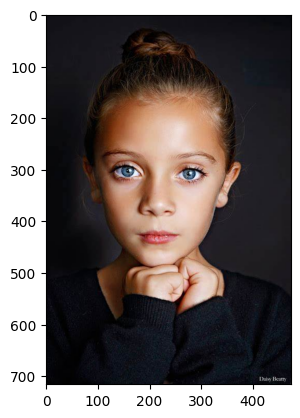

In [6]:
plt.imshow(content_image);

In [7]:
type(content_image)

PIL.JpegImagePlugin.JpegImageFile

In [8]:
content_image = tf.keras.preprocessing.image.img_to_array(content_image)

In [9]:
type(content_image), content_image.shape, content_image.min(), content_image.max()

(numpy.ndarray, (716, 474, 3), 0.0, 255.0)

In [10]:
content_image = content_image / 255

In [11]:
content_image.min(), content_image.max()

(0.0, 1.0)

In [12]:
content_image

array([[[0.06666667, 0.0627451 , 0.08627451],
        [0.06666667, 0.0627451 , 0.08627451],
        [0.06666667, 0.0627451 , 0.08627451],
        ...,
        [0.02745098, 0.03137255, 0.05098039],
        [0.03921569, 0.04313726, 0.0627451 ],
        [0.03921569, 0.04313726, 0.0627451 ]],

       [[0.06666667, 0.0627451 , 0.08627451],
        [0.06666667, 0.0627451 , 0.08627451],
        [0.06666667, 0.0627451 , 0.08627451],
        ...,
        [0.02745098, 0.03137255, 0.05098039],
        [0.03921569, 0.04313726, 0.0627451 ],
        [0.03921569, 0.04313726, 0.0627451 ]],

       [[0.06666667, 0.0627451 , 0.08627451],
        [0.06666667, 0.0627451 , 0.08627451],
        [0.06666667, 0.0627451 , 0.08627451],
        ...,
        [0.02745098, 0.03137255, 0.05098039],
        [0.03921569, 0.04313726, 0.0627451 ],
        [0.03921569, 0.04313726, 0.0627451 ]],

       ...,

       [[0.09803922, 0.09803922, 0.10588235],
        [0.        , 0.        , 0.00784314],
        [0.03921569, 0

In [13]:
content_image = content_image[tf.newaxis, :]

In [14]:
content_image.shape

(1, 716, 474, 3)

### Style image

In [15]:
style_image = tf.keras.preprocessing.image.load_img('/content/OilPainting.jpeg')

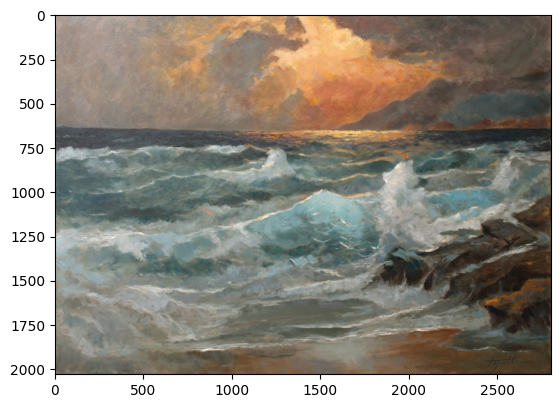

In [16]:
plt.imshow(style_image);

In [17]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image / 255
style_image = style_image[tf.newaxis, :]
style_image.shape

(1, 2029, 2803, 3)

In [18]:
style_image = tf.keras.preprocessing.image.load_img('/content/OilPainting.jpeg')

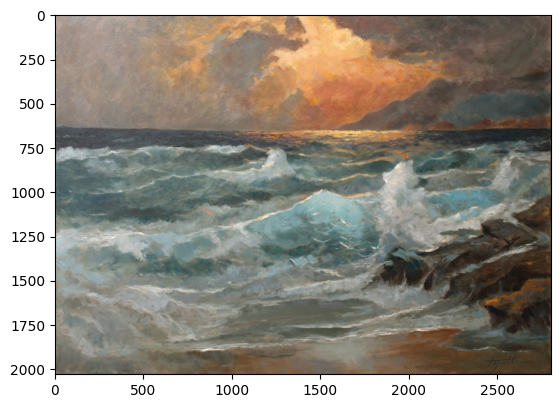

In [19]:
plt.imshow(style_image);

In [20]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image / 255
style_image = style_image[tf.newaxis, :]
style_image.shape

(1, 2029, 2803, 3)

## Building the neural network

In [21]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [22]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
print(num_content_layers, num_style_layers)

1 5


In [23]:
[network.get_layer(name).output for name in style_layers]

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [24]:
network.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [25]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  network = tf.keras.Model(inputs = [vgg.input], outputs = outputs)

  return network

In [26]:
style_extractor = vgg_layers(style_layers)

In [27]:
style_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [28]:
style_extractor.outputs

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [29]:
style_outputs = style_extractor(style_image)

In [30]:
len(style_outputs)

5

In [31]:
style_outputs[1]

<tf.Tensor: shape=(1, 1014, 1401, 128), dtype=float32, numpy=
array([[[[ 0.        ,  0.        ,  0.        , ...,  7.210479  ,
           0.        , 13.039521  ],
         [ 0.        ,  0.        ,  1.9992695 , ...,  3.6534874 ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  1.6514077 , ...,  5.0020432 ,
           0.        ,  1.0902461 ],
         ...,
         [ 0.        ,  0.        ,  1.1687695 , ...,  4.654574  ,
           0.        ,  1.0191063 ],
         [ 0.        ,  0.        ,  1.1867585 , ...,  5.6982346 ,
           0.        ,  1.3491541 ],
         [ 0.        ,  0.        ,  5.113443  , ..., 10.109321  ,
           0.        ,  0.        ]],

        [[ 0.        ,  4.781934  ,  0.        , ...,  6.7505703 ,
           1.8411211 , 13.564257  ],
         [ 0.        ,  5.4167743 ,  0.        , ...,  0.27588597,
           2.7729437 ,  0.        ],
         [ 0.        ,  5.1931553 ,  0.        , ...,  4.3743587 ,
           3.6195273 , 

In [32]:
style_outputs[0].shape, style_outputs[1].shape, style_outputs[2].shape, style_outputs[3].shape, style_outputs[4].shape

(TensorShape([1, 2029, 2803, 64]),
 TensorShape([1, 1014, 1401, 128]),
 TensorShape([1, 507, 700, 256]),
 TensorShape([1, 253, 350, 512]),
 TensorShape([1, 126, 175, 512]))

In [33]:
# Loss between the style and the content image (see original paper, section 2.2)
def gram_matrix(layer_activation):
  result = tf.linalg.einsum('bijc,bijd->bcd', layer_activation, layer_activation)
  input_shape = tf.shape(layer_activation)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

  return result / num_locations

In [34]:
style_outputs[0]

<tf.Tensor: shape=(1, 2029, 2803, 64), dtype=float32, numpy=
array([[[[0.        , 0.27836353, 0.17349154, ..., 0.3531142 ,
          0.6493083 , 0.28820884],
         [0.        , 0.42029837, 0.50704837, ..., 0.        ,
          1.707532  , 1.3033711 ],
         [0.        , 0.41744655, 0.49996138, ..., 0.        ,
          1.7045138 , 1.2892854 ],
         ...,
         [0.        , 0.3504023 , 0.3890677 , ..., 0.34384936,
          1.360353  , 1.1064312 ],
         [0.        , 0.33755133, 0.36143097, ..., 0.3801285 ,
          1.2873691 , 1.0368109 ],
         [0.7700093 , 0.3412869 , 0.4780749 , ..., 0.69912726,
          1.6486901 , 1.5645196 ]],

        [[0.        , 0.33286446, 0.05619343, ..., 0.        ,
          0.        , 0.        ],
         [0.7495721 , 0.5170759 , 0.45524073, ..., 0.        ,
          0.47730812, 0.618975  ],
         [0.73942757, 0.51842254, 0.4646886 , ..., 0.        ,
          0.51974094, 0.6587684 ],
         ...,
         [0.9898319 , 0.426

In [35]:
gram_matrix(style_outputs[0])

<tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[0.53981435, 0.2646149 , 0.23297633, ..., 0.0823508 ,
         0.35296255, 0.3967992 ],
        [0.2646149 , 0.15350683, 0.12664044, ..., 0.02708528,
         0.17515464, 0.19716191],
        [0.23297633, 0.12664044, 0.11013508, ..., 0.02191119,
         0.15451145, 0.17591947],
        ...,
        [0.0823508 , 0.02708528, 0.02191119, ..., 0.0487108 ,
         0.05409696, 0.05390143],
        [0.35296255, 0.17515464, 0.15451145, ..., 0.05409696,
         0.23659167, 0.2638591 ],
        [0.3967992 , 0.19716191, 0.17591947, ..., 0.05390143,
         0.2638591 , 0.29736954]]], dtype=float32)>

In [36]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super().__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs * 255.0
    # 0 - 1
    # -127.50 - 127.50
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs = outputs[:self.num_style_layers]
    content_outputs = outputs[self.num_style_layers:]

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [37]:
style_layers, content_layers

(['block1_conv1',
  'block2_conv1',
  'block3_conv1',
  'block4_conv1',
  'block5_conv1'],
 ['block4_conv2'])

In [38]:
extractor = StyleContentModel(style_layers, content_layers)

In [39]:
results = extractor(content_image)

In [40]:
results

{'content': {'block4_conv2': <tf.Tensor: shape=(1, 89, 59, 512), dtype=float32, numpy=
  array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
            1.4767900e+03, 1.0544025e+02, 0.0000000e+00],
           [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
            1.5678318e+03, 0.0000000e+00, 0.0000000e+00],
           [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
            1.1860195e+03, 4.9546032e+01, 0.0000000e+00],
           ...,
           [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
            1.2915361e+03, 1.2878995e+01, 0.0000000e+00],
           [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
            1.2151769e+03, 7.4187889e+01, 0.0000000e+00],
           [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
            1.1123588e+03, 1.8753432e+02, 0.0000000e+00]],
  
          [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
            6.0445831e+02, 4.8047762e+00, 0.0000000e+00],
           [0.0000000e+00, 0.0000000e+00, 0.0000000e+

In [41]:
for key, value in results.items():
  print(key, value.keys())

content dict_keys(['block4_conv2'])
style dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


In [42]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [43]:
len(style_targets), len(content_targets)

(5, 1)

In [44]:
new_image = tf.Variable(content_image)

In [45]:
content_weight = 1
style_weight = 100

In [46]:
optimizer = tf.optimizers.Adam(learning_rate=0.02)

## Training

In [47]:
expected_output = np.array([10000, 15000])
predictions = np.array([8000, 15900])

In [48]:
np.sum(abs(expected_output - predictions)) / 2

1450.0

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [50]:
mean_absolute_error(expected_output, predictions)

1450.0

In [51]:
mean_squared_error(expected_output, predictions)

2405000.0

In [52]:
((expected_output - predictions) ** 2).mean()

2405000.0

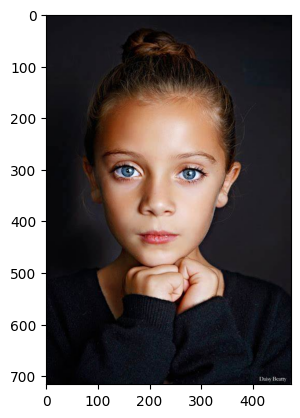

In [53]:
plt.imshow(tf.squeeze(content_image, axis = 0));

Epoch 500 | content loss: 235440.84375 | style loss: 40348824.0 | total loss 807211904.0


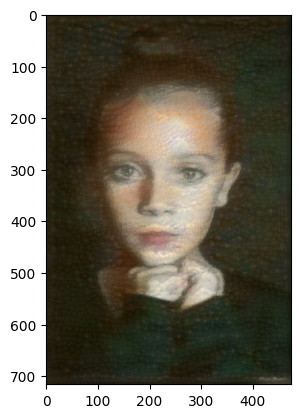

Epoch 1000 | content loss: 241238.53125 | style loss: 18896854.0 | total loss 378178336.0


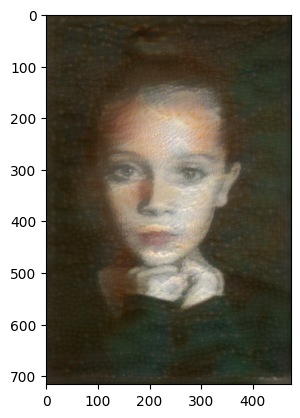

Epoch 1500 | content loss: 250869.984375 | style loss: 15346848.0 | total loss 307187840.0


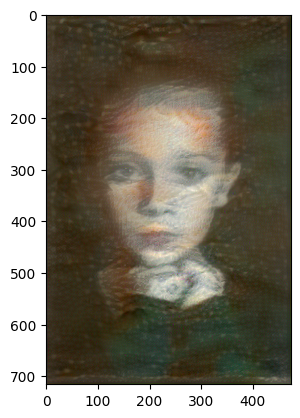

Epoch 2000 | content loss: 252824.015625 | style loss: 5434531.0 | total loss 108943448.0


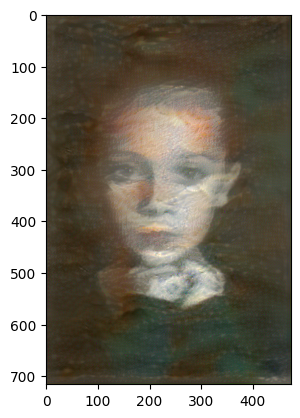

Epoch 2500 | content loss: 256503.4375 | style loss: 6803054.5 | total loss 136317584.0


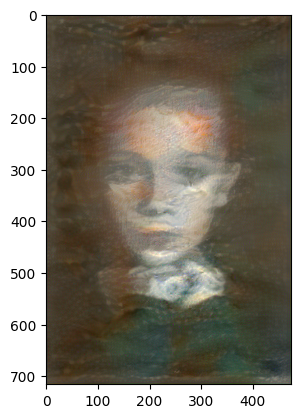

Epoch 3000 | content loss: 282480.75 | style loss: 19129704.0 | total loss 382876576.0


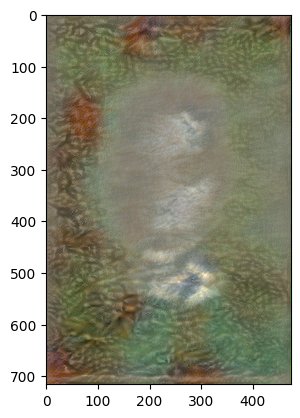

In [54]:
epochs = 3000
print_every = 500

for epoch in range(epochs):
  with tf.GradientTape() as tape:
    outputs = extractor(new_image)

    content_outputs = outputs['content']
    style_outputs = outputs['style']

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])

    total_loss = content_loss * content_weight / num_content_layers + style_loss * style_weight / num_style_layers

  gradient = tape.gradient(total_loss, new_image)
  optimizer.apply_gradients([(gradient, new_image)])

  new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))

  if (epoch + 1) % print_every == 0:
    print('Epoch {} | content loss: {} | style loss: {} | total loss {}'.format(epoch + 1, content_loss, style_loss, total_loss))
    plt.imshow(tf.squeeze(new_image, axis = 0))
    plt.show()

## Visualizing the results

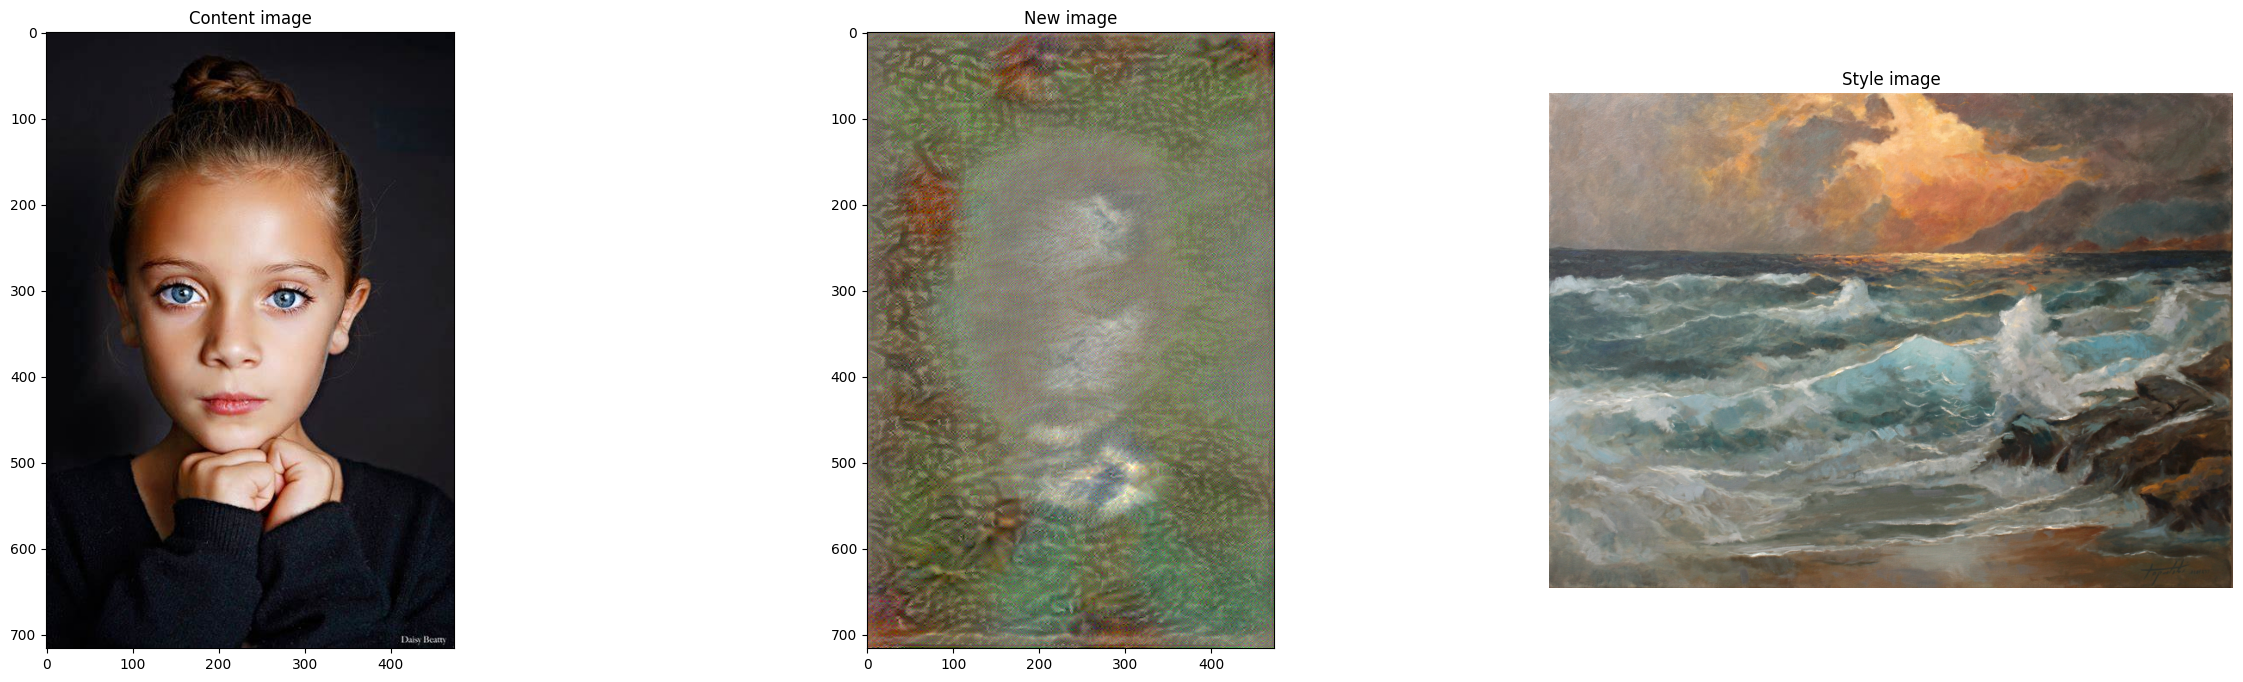

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,8))
ax1.imshow(tf.squeeze(content_image, axis = 0))
ax1.set_title('Content image')
ax2.imshow(tf.squeeze(new_image, axis = 0))
ax2.set_title('New image')
ax3.imshow(tf.squeeze(style_image, axis = 0))
ax3.set_title('Style image')
plt.axis('off');

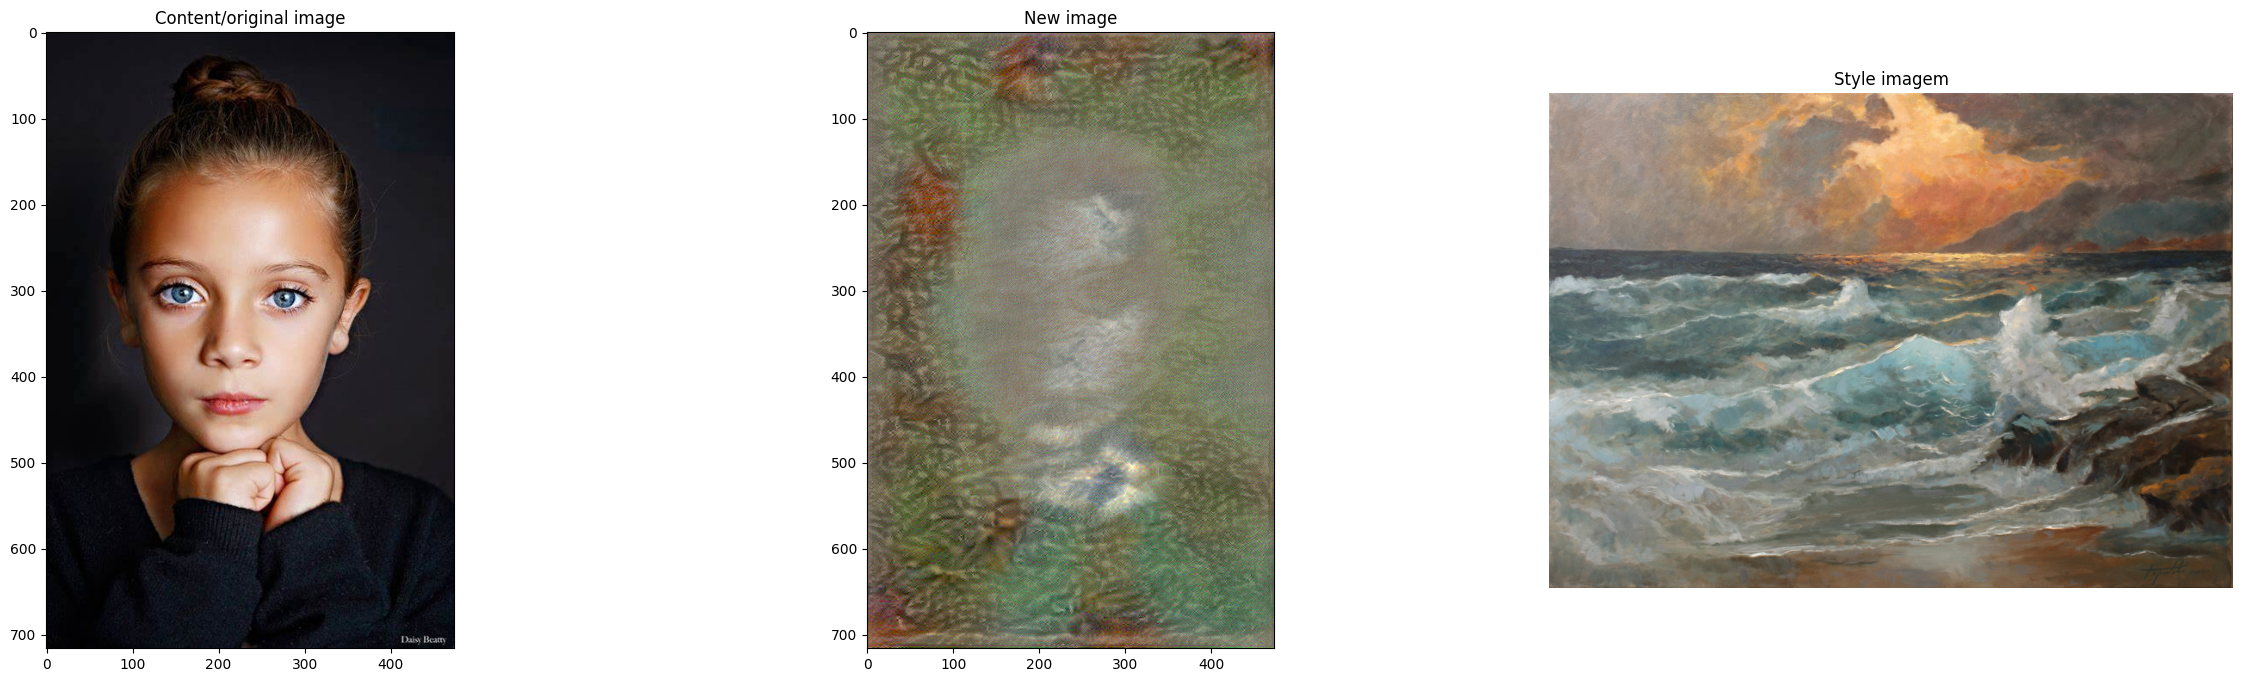

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
ax1.imshow(tf.squeeze(content_image, axis = 0))
ax1.set_title('Content/original image')
ax2.imshow(tf.squeeze(new_image, axis = 0))
ax2.set_title('New image')
ax3.imshow(tf.squeeze(style_image, axis = 0))
ax3.set_title('Style imagem')
plt.axis('off');